In [1]:
!unzip images.zip

Archive:  images.zip
  inflating: images/image_621.jpg    
  inflating: images/image_383.jpg    
  inflating: images/image_821.jpg    
  inflating: images/image_633.jpg    
  inflating: images/image_898.jpg    
  inflating: images/image_193.jpg    
  inflating: images/image_937.jpg    
  inflating: images/image_817.jpg    
  inflating: images/image_861.jpg    
  inflating: images/image_264.jpg    
  inflating: images/image_428.jpg    
  inflating: images/image_729.jpg    
  inflating: images/image_275.jpg    
  inflating: images/image_501.jpg    
  inflating: images/image_847.jpg    
  inflating: images/image_250.jpg    
  inflating: images/image_683.jpg    
  inflating: images/image_227.jpg    
  inflating: images/image_685.jpg    
  inflating: images/image_816.jpg    
  inflating: images/image_679.jpg    
  inflating: images/image_754.jpg    
  inflating: images/image_950.jpg    
  inflating: images/image_211.jpg    
  inflating: images/image_803.jpg    
  inflating: images/image_831

In [2]:
!pip install torch torchvision pandas pillow matplotlib

In [3]:
import os, pandas as pd, torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MultiLabelDataset(Dataset):
    def __init__(self, image_dir, label_file):
        self.image_dir=image_dir
        data=[]
        with open(label_file) as f:
            for line in f:
                p=line.strip().split()
                data.append([p[0]]+p[1:])
        self.df=pd.DataFrame(data,columns=["image","a1","a2","a3","a4"])
        self.t=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

    def __len__(self): return len(self.df)

    def __getitem__(self,idx):
        r=self.df.iloc[idx]
        path=os.path.join(self.image_dir,r["image"])
        if not os.path.exists(path): return self.__getitem__((idx+1)%len(self))
        img=self.t(Image.open(path).convert("RGB"))

        labels,mask=[],[]
        for c in ["a1","a2","a3","a4"]:
            v=r[c]
            if v=="NA": labels.append(0);mask.append(0)
            else: labels.append(int(v));mask.append(1)

        return img,torch.tensor(labels).float(),torch.tensor(mask).float()

def get_model():
    m=models.resnet18(weights="IMAGENET1K_V1")
    m.fc=nn.Linear(m.fc.in_features,4)
    return m

def masked_loss(o,t,m):
    loss=F.binary_cross_entropy_with_logits(o,t,reduction="none")
    loss=loss*m
    return loss.sum()/m.sum()

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Epoch 0 0.5435723212898754
Epoch 1 0.32893117553875095
Epoch 2 0.18997117510584535
Epoch 3 0.10469388754152861
Epoch 4 0.06640715042098624


Text(0, 0.5, 'training_loss')

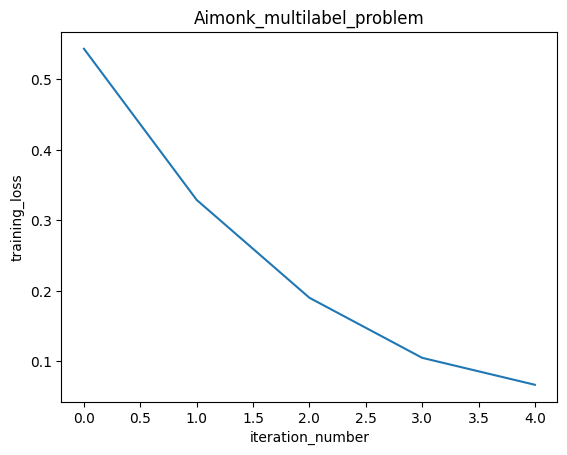

In [4]:
dataset=MultiLabelDataset("images","labels.txt")
loader=DataLoader(dataset,batch_size=16,shuffle=True)

device="cuda" if torch.cuda.is_available() else "cpu"
print("Device:",device)

model=get_model().to(device)
opt=torch.optim.Adam(model.parameters(),lr=1e-4)

losses=[]
for epoch in range(5):
    total=0
    for x,y,m in loader:
        x,y,m=x.to(device),y.to(device),m.to(device)
        o=model(x)
        loss=masked_loss(o,y,m)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total+=loss.item()

    avg=total/len(loader)
    losses.append(avg)
    print("Epoch",epoch,avg)

torch.save(model.state_dict(),"model.pth")

plt.plot(losses)
plt.title("Aimonk_multilabel_problem")
plt.xlabel("iteration_number")
plt.ylabel("training_loss")

In [7]:
img=Image.open("images/image_0.jpg").convert("RGB")
t=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])
img=t(img).unsqueeze(0).to(device)

out=torch.sigmoid(model(img))[0]
attrs=["Attr1","Attr2","Attr3","Attr4"]
print("Present:",[attrs[i] for i,v in enumerate(out) if v>0.5])

Present: ['Attr1', 'Attr2', 'Attr3']
